In [6]:
import torch
import dataclasses
import mediapy
from huggingface_hub import PyTorchModelHubMixin
from huggingface_hub import ModelCard
from gpudrive.networks.late_fusion import NeuralNet
import matplotlib.pyplot as plt
from collections import defaultdict
import random

from gpudrive.env.config import EnvConfig
from gpudrive.env.env_torch import GPUDriveTorchEnv
from gpudrive.visualize.utils import img_from_fig
from gpudrive.env.dataset import SceneDataLoader
from gpudrive.utils.config import load_config
from gpudrive.utils.checkpoint import load_policy
from gpudrive.utils.rollout import rollout

from PIL import Image

In [7]:
# Configs model has been trained with
config = load_config("/home/emerge/gpudrive/baselines/ppo/config/ppo_base_puffer")

print(config)

num_envs = 5
device = "cpu"
max_agents = 64

config.environment.reward_type = "reward_conditioned"
config.environment.condition_mode = "fixed"
config.environment.agent_type = torch.Tensor([-0.2, 1.0, -0.2])

{'mode': 'train', 'use_rnn': False, 'eval_model_path': None, 'baseline': False, 'data_dir': 'data/processed/training', 'continue_training': False, 'model_cpt': None, 'environment': {'name': 'gpudrive', 'num_worlds': 75, 'k_unique_scenes': 75, 'max_controlled_agents': 64, 'ego_state': True, 'road_map_obs': True, 'partner_obs': True, 'norm_obs': True, 'remove_non_vehicles': False, 'lidar_obs': False, 'reward_type': 'reward_conditioned', 'collision_weight': -0.75, 'off_road_weight': -0.75, 'goal_achieved_weight': 1.0, 'dynamics_model': 'classic', 'collision_behavior': 'ignore', 'dist_to_goal_threshold': 2.0, 'polyline_reduction_threshold': 0.1, 'sampling_seed': 42, 'obs_radius': 50.0, 'action_space_steer_disc': 13, 'action_space_accel_disc': 7}, 'wandb': {'entity': '', 'project': 'kshotagents', 'group': 'reward_conditioned', 'mode': 'online', 'tags': ['ppo', 'ff']}, 'train': {'exp_id': 'PPO', 'seed': 42, 'cpu_offload': False, 'device': 'cuda', 'bptt_horizon': 1, 'compile': False, 'compile

In [8]:
agent = load_policy(
    model_name="model_PPO____R_10000__03_19_19_05_33_518_006000",
    path_to_cpt="/home/emerge/gpudrive/examples/experimental/models",
    env_config=config.environment,
    device=device
);

Load model from /home/emerge/gpudrive/examples/experimental/models/model_PPO____R_10000__03_19_19_05_33_518_006000.pt


In [9]:
# Create data loader
train_loader = SceneDataLoader(
    root='/home/emerge/gpudrive/data/processed/training/',
    batch_size=num_envs,
    dataset_size=100,
    sample_with_replacement=False,
)

# Set params
config = config.environment
env_config = dataclasses.replace(
    EnvConfig(),
    norm_obs=config.norm_obs,
    dynamics_model=config.dynamics_model,
    collision_behavior=config.collision_behavior,
    dist_to_goal_threshold=config.dist_to_goal_threshold,
    polyline_reduction_threshold=config.polyline_reduction_threshold,
    remove_non_vehicles=config.remove_non_vehicles,
    lidar_obs=config.lidar_obs,
    disable_classic_obs=config.lidar_obs,
    obs_radius=config.obs_radius,
    steer_actions = torch.round(
        torch.linspace(-torch.pi, torch.pi, config.action_space_steer_disc), decimals=3  
    ),
    accel_actions = torch.round(
        torch.linspace(-4.0, 4.0, config.action_space_accel_disc), decimals=3
    ),
    reward_type=config.reward_type,
    condition_mode=config.condition_mode,
    agent_type=config.agent_type,
)

# Make env
env = GPUDriveTorchEnv(
    config=env_config,
    data_loader=train_loader,
    max_cont_agents=64, #config.max_controlled_agents,
    device=device,
)

In [44]:
def run_multiple_rollouts(env, agent, num_rollouts=2, device='cpu'):
    """
    Run multiple rollouts with different collision weights and store trajectories.
    Stores agent positions as a tensor of shape [num_envs, num_rollouts, agents, steps, 2].
    
    Args:
        env: The environment (can be batched with multiple environments)
        agent: The policy
        num_rollouts: Number of rollouts to perform
        device: Device to run on
        
    Returns:
        all_trajectories: Dictionary containing trajectories and weights
    """
    import torch
    import random
    import numpy as np
    
    # Get environment info to determine dimensions
    obs = env.reset(agent_type=torch.Tensor([0.0, 0.0, 0.0]))
    num_envs = obs.shape[0] if hasattr(obs, 'shape') else 1
    
    # Lists to collect data across rollouts
    all_agent_positions = []
    collision_weights = []
    goal_weights = []
    offroad_weights = []
    all_goal_achieved = []
    all_collided = []
    all_off_road = []
    all_episode_lengths = []
    
    for i in range(num_rollouts):
        print(f"Running rollout {i+1}/{num_rollouts}")
        
        # Sample separate weights
        collision_weight = random.uniform(-3.0, 1.0)
        goal_weight = 1.0
        off_road_weight = -3.0
        
        agent_weights = torch.Tensor([collision_weight, goal_weight, off_road_weight])
        print(f"Using weights: {agent_weights}")
        
        # Run rollout with these weights
        (
            goal_achieved_count,
            frac_goal_achieved,
            collided_count,
            frac_collided,
            off_road_count,
            frac_off_road,
            not_goal_nor_crash_count,
            frac_not_goal_nor_crash_per_scene,
            controlled_agents_per_scene,
            sim_state_frames,
            agent_positions,
            episode_lengths
        ) = rollout(
            env=env,
            policy=agent,
            device=device,
            deterministic=False,
            return_agent_positions=True,
            set_agent_type=True,
            agent_weights=agent_weights,
        )
        
        # Store weights and positions
        collision_weights.append(collision_weight)
        goal_weights.append(goal_weight)
        offroad_weights.append(off_road_weight)
        all_agent_positions.append(agent_positions.clone().detach())
        
        # Store other metrics
        all_goal_achieved.append(goal_achieved_count)
        all_collided.append(collided_count)
        all_off_road.append(off_road_count)
        all_episode_lengths.append(episode_lengths)
    
    # Stack agent positions along a new dimension at position 1 (after num_envs)
    # From list of [num_envs, num_agents, time_steps, 2] to tensor of [num_envs, num_rollouts, num_agents, time_steps, 2]
    stacked_positions = torch.stack(all_agent_positions, dim=1)
    
    # Return organized data
    all_trajectories = {
        'collision_weights': torch.tensor(collision_weights),
        'goal_weights': torch.tensor(goal_weights),
        'offroad_weights': torch.tensor(offroad_weights),
        'agent_positions': stacked_positions,  # Shape: [num_envs, num_rollouts, num_agents, time_steps, 2]
        'goal_achieved': all_goal_achieved,
        'collided': all_collided,
        'off_road': all_off_road,
        'episode_lengths': all_episode_lengths
    }
    
    return all_trajectories

In [45]:
trajs = run_multiple_rollouts(
    env=env,
    agent=agent,
    num_rollouts=20,
    device='cpu'
);

Running rollout 1/20
Using weights: tensor([-0.7195,  1.0000, -3.0000])
Running rollout 2/20
Using weights: tensor([-1.5693,  1.0000, -3.0000])
Running rollout 3/20
Using weights: tensor([-0.4519,  1.0000, -3.0000])
Running rollout 4/20
Using weights: tensor([-1.6423,  1.0000, -3.0000])
Running rollout 5/20
Using weights: tensor([-0.9070,  1.0000, -3.0000])
Running rollout 6/20
Using weights: tensor([ 0.8978,  1.0000, -3.0000])
Running rollout 7/20
Using weights: tensor([-0.3654,  1.0000, -3.0000])
Running rollout 8/20
Using weights: tensor([-2.8612,  1.0000, -3.0000])
Running rollout 9/20
Using weights: tensor([-1.7468,  1.0000, -3.0000])
Running rollout 10/20
Using weights: tensor([-2.3545,  1.0000, -3.0000])
Running rollout 11/20
Using weights: tensor([-2.1445,  1.0000, -3.0000])
Running rollout 12/20
Using weights: tensor([ 0.9851,  1.0000, -3.0000])
Running rollout 13/20
Using weights: tensor([-0.1805,  1.0000, -3.0000])
Running rollout 14/20
Using weights: tensor([ 0.2572,  1.000

In [46]:
trajs['agent_positions'].shape

torch.Size([5, 20, 64, 91, 2])

In [47]:
trajs['collision_weights']

tensor([-0.7195, -1.5693, -0.4519, -1.6423, -0.9070,  0.8978, -0.3654, -2.8612,
        -1.7468, -2.3545, -2.1445,  0.9851, -0.1805,  0.2572, -2.2591, -0.6897,
        -0.5889, -0.6967, -1.2825, -1.3794])

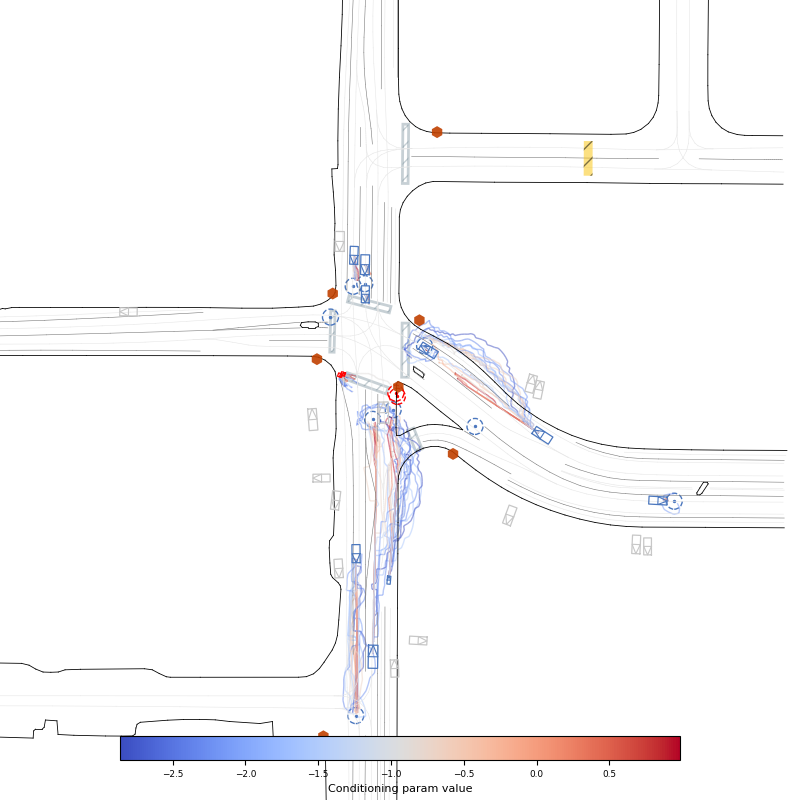

In [48]:
env.vis.figsize = (8, 8)

# Plot simulator state with the stacked trajectories
_ = env.reset(agent_type=torch.Tensor([-0.2, 1.0, -0.2]))
img = env.vis.plot_simulator_state(
    env_indices=[2], 
    agent_positions=trajs['agent_positions'],  # Pass stacked trajectories directly
    zoom_radius=100,
    multiple_rollouts=True,  
    line_alpha=0.5,          
    line_width=1.0,     
    weights=trajs['collision_weights'],     
    colorbar=True, 
)[0]

Image.fromarray(img_from_fig(img))

In [43]:
# Save the figure with high DPI
fig = img  # Since img is already the figure object
filename = "effect_of_rew_cond_2.png"
fig.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
print(f"Figure saved as {filename}")

Figure saved as effect_of_rew_cond_2.png
